In [1]:
#| include: false
%matplotlib inline

In [2]:
#| default_exp feature_extraction
#| export
import os
import pickle
from dataclasses import dataclass
import enum

import cv2
from dataclasses_json import dataclass_json
import ffmpeg
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import skvideo.io
from tqdm import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm


from experiment_utils.constants import *
from experiment_utils.utils import getLogger

In [3]:
#| export
logger = getLogger()

In [4]:
#| export
def get_video_size(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    width = int(video_info['width'])
    height = int(video_info['height'])
    
    return width, height

def get_video_num_frames(filename):
    logger.info('Getting video size for {!r}'.format(filename))
    probe = ffmpeg.probe(filename)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    
    return int(video_info['nb_frames'])

## Downsampling

Since the data in it's original format is approx 32G in size, we need to downsample

We can downsample in multiple ways:

1. Framerate
2. Color
3. Frame Size

In [5]:
#| export
class ColorSpace(str, enum.Enum):
    RGB = "RGB"
    BW = "BW"

@dataclass
class DownsampleConfig:
    height: int
    width: int
    fps_ratio: int
    col_space: ColorSpace
        
    __MAGIC = 'downsample_'
    
    def __str__(self):
        return f'{self.__MAGIC}_{self.width}x{self.height}_{self.fps_ratio}_{self.col_space}'
    
    @classmethod
    def from_str(cls, downsample_str: str):
        if downsample_str[:len(cls.__MAGIC)] != cls.__MAGIC:
            raise ValueError("Could not create DownsampleConfig from string: " + downsample_str)
        
        width, *rest = downsample_str[len(cls.__MAGIC):].split('x')
        fields = rest[0].split('_')
        
        height, fps_ratio, col_space, *rest = fields
        
        return DownsampleConfig(height=int(height),
                                width=int(width),
                                fps_ratio=int(fps_ratio),
                                col_space=ColorSpace(col_space))

In [13]:
#| export
def get_downsampled_frames(input_filename: str, downsample_config: DownsampleConfig) -> np.array:
    cap = cv2.VideoCapture(input_filename)
    
    frames = []
    count = 0
    
    with tqdm(total=get_video_num_frames(input_filename)) as progress_bar:
        while cap.isOpened():
            ret, frame = cap.read()

            if ret:
                count += downsample_config.fps_ratio
                progress_bar.update(downsample_config.fps_ratio)
                cap.set(cv2.CAP_PROP_POS_FRAMES, count)
            else:
                cap.release()
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized_image = resize(frame, (downsample_config.height, downsample_config.width))

            if downsample_config.col_space == ColorSpace.BW:
                rgb_weights = [0.2989, 0.5870, 0.1140]
                grayscale_image = np.dot(resized_image[...,:3], rgb_weights)
                int_frame = (grayscale_image * 255).astype(np.uint8)
            else:
                int_frame = (resized_image * 255).astype(np.uint8)

            frames.append(int_frame)
    
    return frames

In [14]:
def get_sample_videos_paths():
    clips_dir = os.path.join(DATA_DIR, 'clips')
    return [os.path.join(clips_dir, name) for name in os.listdir(clips_dir)]

In [15]:
all_vids = get_sample_videos_paths()
all_vids

['/code/data/clips/test_clip_1.mp4']

In [16]:
downsampled_frames = get_downsampled_frames(all_vids[0], DownsampleConfig.from_str('downsample_640x480_60_RGB'))

[INFO] 2022-10-02 11:41:11,335 root        : Getting video size for '/code/data/clips/test_clip_1.mp4'
6360it [00:14, 427.82it/s]                                                                                                                                                                                                                  


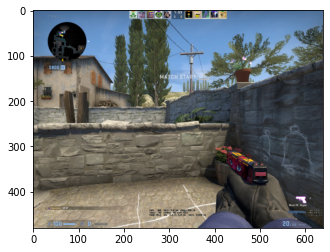

In [17]:
plt.imshow(downsampled_frames[0])